# Funciones

In [2]:
import pandas as pd
#from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from sklearn.linear_model import LinearRegression
from skspatial.objects import Points, Line, Plane, Vector, Point
from skspatial.plotting import plot_3d
import copy
import scipy
import statistics 
from pathlib import Path
import sys
from skimage.measure import EllipseModel
from ast import literal_eval
from biopandas.pdb import PandasPdb
import sklearn
import os, sys

### 1. Lee el archivo con información de las hebras beta del tim barrel, crea un dataframe sólo con los CA y cuenta el número de hebras que tiene el tim barrel.

In [3]:
def datos(archivo, fusion):
    txt = pd.read_table(path/archivo, names=colnames, header=None)#, index_col='num_res') #Uso como indice num_res
    print(archivo)
    
    txt.drop(['ignorar1', 'ignorar2'], axis = 'columns', inplace=True)
    ca=txt[txt['atomo']=='CA']
    cb=txt[txt['atomo']=='CB']
    n=txt[txt['atomo']=='N']
    o=txt[txt['atomo']=='O']
    
    if fusion:
        fusion_hebras(ca)
        fusion_hebras(cb)
        fusion_hebras(n)
        fusion_hebras(o)
    
    n_hebras=ca['hebra'].nunique() #numero de hebras
    return n_hebras, ca, txt, cb, n, o
#Guardar el número de hebras inicial que tienen para posterior comparación con anotaciones de STRIDE y el futuro combinado
#Posteriormente haremos un merge para unir los df de CA y CB

### 2. Fusión de hebras

Si el residuo n+1 es continuo o se separa del residuo n por 1 aminoácido (ejem. n=2 numres - n+1=4 numres), entonces al residuo n+1 se le asigna la misma hebra que el n. Con este paso se logran unir las anotaciones de las hebras 

In [4]:
def fusion_hebras(df):
    iterator = iter(df.index)
    b=next(iterator)
    c=1
    while c < len(df):
        c=c+1
        a=b
        b=next(iterator)
        if df.at[b,'hebra'] == df.at[a,'hebra']:
            pass
        elif abs(df['num_res'][b] - df['num_res'][a])<=2: 
            df.at[b,'hebra']=df.at[a,'hebra']

### 3. Renumerar nombres de las hebras para empezar por hebra 1.

In [5]:
def renumera_hebras_dic(df):
    dic_renumera={}
    for i, hebra in enumerate(df["hebra"].unique()):
        dic_renumera[hebra]=i
    return dic_renumera

### 4. Translada coordenadas al centro del dominio. Ajusta ejes a coordenadas de hebras centradas en centroide de hebra. Acomoda ejes en la misma dirección que la hebra. 
Crea matriz de rotación para alinear eje central a (0,0,1) (valor en z, puede ser + o -) y así rotar todas las coordenadas.

#### 4.1 retry_rotate(ca,direction,cb,n,o,compara_signo)
Función que hace repetir la rotación y compara el error.
Corre a *rotate_barrel(barrel_df,direction,barrel_CB,barrel_N,barrel_O)*

In [6]:
def retry_rotate(ca,direction,cb,n,o,compara_signo):
    """
    Hace varios intentos de rotar el barril, a base de llamar
    rotate_barrel() varias veces, por pasos.
    Si no lo logra, regresa None.
    
    barrel_df: dataframe (ver 'ca_df' en central_ax)
    direction: vector que indica la direccion deseada para el eje
               central del barril
    """
    error_primero,central,ejes,dic_ejes,rotado_ca,rotado_cb,rotado_n,rotado_o,num_anti = rotate_barrel(ca,direction,cb,n,o,compara_signo)
    if error_primero < 0.00001:
        #print("error pequeño en el primer intento, acaba la funcion, error:", error_primero)
        return error_primero,central,ejes,dic_ejes,rotado_ca,rotado_cb,rotado_n,rotado_o,num_anti
    
    #Probar con todos los steps -> direction. Guardar errores para encontrar mejor error (el min).
    mid_steps = [[1,0,0],[0,1,0],[0,0,1],[1,1,1],
                 [-1,0,0],[0,-1,0],[0,0,-1],[-1,-1,-1],
                 [1,1,0],[1,0,1],[0,1,1],
                 [-1,-1,0],[-1,0,-1],[0,-1,-1],
                 [-1,1,0],[-1,0,1],[0,-1,1],
                 [1,-1,0],[1,0,-1],[0,1,-1]]
    #print("error grande, ",error_primero," inicia steps")
    steps_list={}
    for step in mid_steps:
        #print("nuevo step:", step)
        error,central,ejes,dic_ejes,rotado_ca,rotado_cb,rotado_n,rotado_o,num_anti = rotate_barrel(ca,step,cb,n,o,compara_signo)
        error,central,ejes,dic_ejes,rotado_ca,rotado_cb,rotado_n,rotado_o,num_anti = rotate_barrel(rotado_ca,direction,rotado_cb,rotado_n,rotado_o,compara_signo)
        #print("con dir depues de step", error)
        if error < 0.00001:
            #print("error pequeño después iniciar con step ",step,"acaba la función error: ",error)
            return error,central,ejes,dic_ejes,rotado_ca,rotado_cb,rotado_n,rotado_o,num_anti        
        steps_list[str(step)]=error      
    mejor_step = eval(min(steps_list, key=steps_list.get))
    
    #Si el error sigue siendo grande, probamos iterando tres veces más contra direction, iniciando con el mejor step
    error,central,ejes,dic_ejes,rotado_ca,rotado_cb,rotado_n,rotado_o,num_anti = rotate_barrel(ca,mejor_step,cb,n,o,compara_signo)
    mejor_step_error,central,ejes,dic_ejes,rotado_ca,rotado_cb,rotado_n,rotado_o,num_anti = rotate_barrel(rotado_ca,direction,rotado_cb,rotado_n,rotado_o,compara_signo)
    if error < 0.00001:
        #print("error pequeño después iniciar con step ",mejor_step, "y definir con direccion una vez 1. Acaba la funcion, error:", mejor_step_error)
        return mejor_step_error,central,ejes,dic_ejes,rotado_ca,rotado_cb,rotado_n,rotado_o,num_anti
    
    error,central,ejes,dic_ejes,rotado_ca,rotado_cb,rotado_n,rotado_o,num_anti = rotate_barrel(rotado_ca,direction,rotado_cb,rotado_n,rotado_o,compara_signo)
    if error < 0.00001:
        #print("error pequeño después iniciar con step ",mejor_step, "y definir con direccion dos veces. Acaba la funcion, error:", error)
        return error,central,ejes,dic_ejes,rotado_ca,rotado_cb,rotado_n,rotado_o,num_anti
        
    error,central,ejes,dic_ejes,rotado_ca,rotado_cb,rotado_n,rotado_o,num_anti = rotate_barrel(rotado_ca,direction,rotado_cb,rotado_n,rotado_o,compara_signo)
    if error < 0.00001:
        #print("error pequeño después iniciar con step ",mejor_step, "y definir con direccion tres veces. Acaba la funcion, error:", error)
        return error,central,ejes,dic_ejes,rotado_ca,rotado_cb,rotado_n,rotado_o,num_anti

    #Si nungún error fue lo suficientemente bueno, entonces se decide entre el primer error, el error del mejor step y el z3 despues de mejor step
    lista_errores_finalistas=[error_primero,mejor_step_error,error]
    final_best=lista_errores_finalistas.index(min(lista_errores_finalistas))
    
    if final_best==2:
        #print("nos quedamos con el mejor step luego rotar a direccion tres veces, acaba la funcion, error: ", error)
        return error,central,ejes,dic_ejes,rotado_ca,rotado_cb,rotado_n,rotado_o,num_anti
    if final_best==0:
        error_primero,central,ejes,dic_ejes,rotado_ca,rotado_cb,rotado_n,rotado_o,num_anti = rotate_barrel(ca,direction,cb,n,o,compara_signo)
        #print('primer direction fue el mejor, acaba la funcion, error: ', error_primero)
        return error_primero,central,ejes,dic_ejes,rotado_ca,rotado_cb,rotado_n,rotado_o,num_anti
    if final_best==1:
        error,central,ejes,dic_ejes,rotado_ca,rotado_cb,rotado_n,rotado_o,num_anti = rotate_barrel(ca,mejor_step,cb,n,o,compara_signo)
        mejor_step_error,central,ejes,dic_ejes,rotado_ca,rotado_cb,rotado_n,rotado_o,num_anti = rotate_barrel(rotado_ca,direction,rotado_cb,rotado_n,rotado_o,compara_signo)
        #print("nos quedamos con el mejor step luego del primer direction, acaba la funcion, error: ", mejor_step_error)
        return mejor_step_error,central,ejes,dic_ejes,rotado_ca,rotado_cb,rotado_n,rotado_o,num_anti
    else:
        print('failed')

#### 4.2. rotate_barrel(ca,direction,cb,n,o,compara_signo)
Función que hace una copia del df. Usa el nuevo df y centra sus coordenadas.

Corre a *central_ax(ca)* para encontrar los ejes de las hebras así como el eje central. El insumo es un dataframe ca con las coordenadas centradas. Lo corre dos veces.

Corre a *rotation_matrix_from_vectors(eje_antes, direction)* para crear una matriz que al multiplicarla por otra, alinee los vectores en una dirección

Corre a *my_rotate(mat,ca.loc[:,["x","y","z"]].to_numpy())* rota coordenadas para obtener los ejes de las hebras rotados y alineados a la dirección del eje central

In [7]:
def rotate_barrel(ca,direction,cb,n,o,compara_signo):
    """
    Intenta rotar el eje central del barril. Pero
    para algunas 'direction's. se requiere hacerlo por pasos,
    llamando a esta funcion 2 o más veces.
    Normalmente se llama desde retry_rotate()
    
    barrel_df: dataframe (ver 'ca_df' en central_ax)
    direction: vector que indica la direccion deseada para el eje
               central del barril
    """
    ca_rot = ca.copy()
    cb_rot = cb.copy()
    n_rot = n.copy()
    o_rot = o.copy()
    
    #Centrar coordenadas
    ca_rot.loc[:,["x","y","z"]] = ca_rot.loc[:,["x","y","z"]] - ca.loc[:,["x","y","z"]].mean()
    cb_rot.loc[:,["x","y","z"]] = cb_rot.loc[:,["x","y","z"]] - ca.loc[:,["x","y","z"]].mean()
    n_rot.loc[:,["x","y","z"]] = n_rot.loc[:,["x","y","z"]] - ca.loc[:,["x","y","z"]].mean()
    o_rot.loc[:,["x","y","z"]] = o_rot.loc[:,["x","y","z"]] - ca.loc[:,["x","y","z"]].mean()
    
    #Trazar ejes que describan mejor las hebras. Identifica por primera vez el eje central
    eje_antes,ejes,dic_ejes,num_anti= central_ax(ca_rot,False,None)
    ###
    if compara_signo:
        #print("primero compara_signo")
        signo_central=np.sign(eje_antes[2])
        
        #Trazar ejes que describan mejor las hebras y cuida que queden viendo hacia la misma dirección. Signos de herbas se comparan con eje antes
        eje_antes2,ejes,dic_ejes,num_anti = central_ax(ca_rot,compara_signo,signo_central)
        
        #Crea matriz de rotación
        rotation_matrix = rotation_matrix_from_vectors(eje_antes2, direction)
        #Usa la matriz de rotación y rota los puntos de ca para empatar con eje Z (+ o -)
        ca_rot.loc[:,["x","y","z"]] = my_rotate(rotation_matrix,ca_rot.loc[:,["x","y","z"]].to_numpy())
        cb_rot.loc[:,["x","y","z"]] = my_rotate(rotation_matrix,cb_rot.loc[:,["x","y","z"]].to_numpy())
        n_rot.loc[:,["x","y","z"]]  = my_rotate(rotation_matrix,n_rot.loc[:,["x","y","z"]].to_numpy())
        o_rot.loc[:,["x","y","z"]]  = my_rotate(rotation_matrix,o_rot.loc[:,["x","y","z"]].to_numpy())   
        
        #Trazar ejes que describan mejor las hebras y cuida que queden viendo hacia la misma dirección. Se corre de nuevo porque las coordenadas han cambiado después de la rotación.
        #Como se usa el eje_antes2, el cuál se calcula antes de la rotación, puede haber diferencias, incluso en el signo si se llega a rotar demasiado.
        ###Por esta razón corremos de nuevo central_ax, para obtener un nuevo central, eje_antes3 (sin cambiar el signo de nadie)
        eje_antes3,ejes,dic_ejes,num_anti= central_ax(ca_rot,False,None)        
        
        #print("segundo compara_signo")
        signo_central=np.sign(eje_antes3[2])
        
        #Trazar ejes que describan mejor las hebras y cuida que queden viendo hacia la misma dirección. Signos de hebras se comparan con eje_antes3
        eje_despues,ejes,dic_ejes,num_anti = central_ax(ca_rot,compara_signo,signo_central)        
    ###
    else:
        #Crea matriz de rotación
        rotation_matrix = rotation_matrix_from_vectors(eje_antes,direction)
        #Usa la matriz de rotación y rota los puntos de ca para empatar con eje Z (+ o -)
        ca_rot.loc[:,["x","y","z"]] = my_rotate(rotation_matrix,ca_rot.loc[:,["x","y","z"]].to_numpy())
        cb_rot.loc[:,["x","y","z"]] = my_rotate(rotation_matrix,cb_rot.loc[:,["x","y","z"]].to_numpy())
        n_rot.loc[:,["x","y","z"]]  = my_rotate(rotation_matrix,n_rot.loc[:,["x","y","z"]].to_numpy())
        o_rot.loc[:,["x","y","z"]]  = my_rotate(rotation_matrix,o_rot.loc[:,["x","y","z"]].to_numpy())

        #Trazar ejes que describan mejor las hebras. Se corre de nuevo porque las coordenadas han cambiado después de la rotación.
        eje_despues,ejes,dic_ejes,num_anti = central_ax(ca_rot,False,None)
    
    #Medir el error entre el eje central obtenido y el vector z
    error = np.linalg.norm( np.cross(eje_despues,direction))
    return error,eje_despues,ejes,dic_ejes,ca_rot,cb_rot,n_rot,o_rot,num_anti

##### 4.2.1. central_ax(ca_rot,compara_signo,signo_central)
Para cada hebra calcula un eje y calcula el eje central junto con su conversión a vectores unitarios

Corre a *line_regres_3d(points)* para ajustar recta a puntos y obtener un vector direccion.

In [8]:
def central_ax(ca_rot,compara_signo,signo_central):
    """
    Encuentra la direccion del eje central de un barril de hebras beta,
    Tambien regresa los vectores (ejes) de ajuste a las hebras

    ca_df: dataframe que incluye esta columnas ["strand","x","y","z"]
           strand denota el numero de hebra (1..8)
           x, y z son las coordenadas de los CA
    """
    num_anti=[]
    dic_ejes = {}
    ejes = np.empty((len(ca_rot["hebra"].unique()),3))
    for strand in ca_rot["hebra"].unique():
        try:
            points= ca_rot.loc[ca_rot['hebra']==strand,["x","y","z"]]
        except:
            continue
        ejes[strand], dic_ejes[strand], anti = line_regres_3d(points,strand,compara_signo,signo_central)
        num_anti.append(anti)
        
    central = np.nanmean(ejes,axis=0)
    return central/np.linalg.norm(central),ejes,dic_ejes, num_anti

In [9]:
#Si z de first_last es negativa tenenemos dos opciones:
 #   Que la hebra sea antiparalela
  #  Que todo el dominio esté volteado

In [10]:
#Si z de vv[0] (primer fila) es negativo, quiere decir que el eje z esta volteando para abajo
#Esto se debe a los puntos
#Si ordenamos los puntos en orden descendente en función de z (del z más negativo al z más positivo)-> 
#obtendremos un vv[0] positivo en z.

In [11]:
#Esta es una función que comprara el signo del eje de la hebra en su componente z (vv[0][2]) contra el signo del eje central
#Esta función se correrá dentro de line_regres_3d(points, strand, antip=True, central)
#Se correrá sólo al final, cuando ya se tenga un presunto eje central contra el cual comparar los signos de los ejes

##### 4.2.1.1 line_regres_3d(points)
Trazar ejes que describan mejor las hebras y cuida que queden viendo hacia la misma dirección

In [12]:
def line_regres_3d(points,strand,compara_signo,signo_central):
    """
    Ajusta una linea a los puntos y regresa el vector de direccion, la
    cual apunta del primer al ultimo punto (del primer al ultimo CA).
    points: ndarray con shape = (n,3) donde n es el numero de puntos
    """
    datamean = np.mean(points,axis=0)
    pts = points - datamean            #centra a los puntos en 0,0,0 a través de la resta de su centroide original
    uu, dd, vv = np.linalg.svd(pts)
    eje = vv[0]                         #eje es un vector unitario que representa a los CA de cada hebra.
    anti=None
    if compara_signo:
        signo_eje=np.sign(eje[2])
        if signo_central==signo_eje:
            pass
            #print("same", "signo_central:",signo_central, " signo hebara:",signo_eje," eje:",eje)
        else:
            #print("strand diff:",strand," signo_central:",signo_central, " signo hebara:",signo_eje," eje:",eje)
            anti=strand
            eje= -1*eje      
    # first_last es un vector que va del primer CA del strand, al último. first_last es positivo si la hebra es positiva
    ##first_last= np.subtract(pts.iloc[-1], pts.iloc[0])
    ##first_last = first_last / np.linalg.norm(first_last)

    # Si eje y end_start apuntan en la misma direccion, same es cercano a 0.0
    # y reve cercano a 2.0. Si apuntan en direcciones opuestas,
    # reve es cercano a 0.0 y same es cercano a 2.0
    ##same=  np.linalg.norm(np.subtract(eje[2], first_last[2]))
    ##reve= np.linalg.norm(np.subtract(-1 * eje[2], first_last[2]))
    # Queremos encontrar hebras antiparalelas
    ##if same > reve:
        ##anti=strand
        #eje= -1 * eje
    ##else:
        ##anti=False
        
    #Retornar eje tal cual svd lo otorga
    return eje, eje, anti

##### 4.2.2 rotation_matrix_from_vectors(vec1, vec2)
Crea una matriz de rotación para rotar el vector dado a una direccion

In [13]:
def rotation_matrix_from_vectors(vec1, vec2):
    """
    Vec2 is direction
    Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.

    From: https://stackoverflow.com/questions/45142959/calculate-rotation-matrix-to-align-two-vectors-in-3d-space
    """
    # a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    a, b = (vec1 / np.linalg.norm(vec1)), (vec2 / np.linalg.norm(vec2)) # Convierte a vectores unitarios
    # a,b=vec1,vec2
    v = np.cross(a, b)
    if any(v): #if not all zeros then
        c = np.dot(a, b)
        s = np.linalg.norm(v)
        kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
        rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
        return rotation_matrix
    else:
        return np.eye(3) #cross of all zeros only occurs on identical directions

In [14]:
def rotation_matrix_from_vectors2(v1, v2):
    # Normalize the vectors
    v1_norm = v1 / np.linalg.norm(v1)
    v2_norm = v2 / np.linalg.norm(v2)

    # Calculate the cosine of the angle between the vectors
    cos_angle = np.dot(v1_norm, v2_norm)

    # Calculate the cross product of the vectors to get the rotation axis
    axis = np.cross(v1_norm, v2_norm)

    # If the vectors are parallel, return the identity matrix
    if np.allclose(axis, 0):
        return np.eye(3)

    # Calculate the angle between the vectors using the arccosine function
    sin_angle = np.sqrt(1 - cos_angle**2)
    angle = np.arctan2(sin_angle, cos_angle)

    # Construct the rotation matrix using the Rodrigues formula
    kx, ky, kz = axis
    c = np.cos(angle)
    s = np.sin(angle)
    rotation_matrix = np.array([[kx**2*(1-c)+c, kx*ky*(1-c)-kz*s, kx*kz*(1-c)+ky*s],
                        [kx*ky*(1-c)+kz*s, ky**2*(1-c)+c, ky*kz*(1-c)-kx*s],
                        [kx*kz*(1-c)-ky*s, ky*kz*(1-c)+kx*s, kz**2*(1-c)+c]])

    return rotation_matrix

##### 4.2.3 my_rotate(rotation_matrix,df_points)
Usa la matriz de rotación y rota los puntos de ca.

Depende de output de *rotation_matrix_from_vectors(eje_antes, direction)*

In [15]:
def my_rotate(rotation_matrix,df_points):
    """
    Aplica una matriz de rotatcion a los puntos sin usar scipy
    Equivale a:
        from scipy.spatial.transform import Rotation as R
        r= R.from_matrix(rotmat)
        rotados= r.apply(df_points)
    """
    rotados=np.zeros(df_points.shape)
    for i, p in enumerate(df_points):
        rotados[i]=rotation_matrix.dot(p)
    return rotados

#### 4.3 plot_strands(ca_df)
Graficar los ejes

In [16]:
def plot_strands(ca_df):
    """
    Para cada hebra del barril grafica vectores que van del
    primer CA de la hebra al ultimo. Las hebras 1 y 8 son rojas
    """
    colors = ["r","g","b","c","m","y","k","r"]
    arrow = []
    for strand in ca_df["hebra"].unique():
        try:
            points= ca_df.loc[ca_df["hebra"]==strand,["x","y","z"]]
        except:
            continue
        # Una flecah tiene 6 coordenadas: 3 definen el origen, 3 definen la direccion(las pendientes)
        arrow.append(np.concatenate( (points.iloc[0],np.subtract(points.iloc[-1],points.iloc[0] )  ) ))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for strand in range(8):
        # print(arrow[strand])
        ax.quiver(*arrow[strand],length=1,normalize=False,color=colors[strand])
    ax.set_xlim([ca_df["x"].min(), ca_df["x"].max()])
    ax.set_ylim([ca_df["y"].min(), ca_df["y"].max()])
    ax.set_zlim([ca_df["z"].min(), ca_df["z"].max()])
    plt.show()


### 5. Calcula el ángulo entre dos vectores de dirección.
* For any two vectors a and b, if a · b is positive, then the angle lies between 0° and 90°;
* If a · b is negative, then the angle lies between 90° and 180°.
* The angle between each of the two vectors among the unit vectors i, j, and k is 90°.

In [17]:
def angle_between(v1, v2):
    dot_pr = v1.dot(v2)
    norms = np.linalg.norm(v1) * np.linalg.norm(v2)
    return np.rad2deg(np.arccos(dot_pr / norms))

In [18]:
np.rad2deg(np.arccos(v1.dot(v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))))

NameError: name 'v1' is not defined

### 6. Encuentra pares de hebras adyacentes
Calcula distancia y ángulo entre ejes de hebras
Calcula distancia entre CA de las hebras más cercanas y con un ángulo dentro del umbral. Si la distancia entre dos o más pares de CA de dos hebras diferentes es menor a 6A o menor a 3.5A entre un par de N-O u O-N, entonces define que esas hebras son adyacentes.

In [19]:
def distancia_interhebra_angulo(dic_ejes, ca, n, o, primera):
    dic_dis={}
    for i in ca["hebra"].unique():
        #Obtencion de coordenadas de la hebra i
        CAcoordi=(ca.loc[ca['hebra']==i, ['x','y','z']]).to_numpy()
        Ncoordi=(n.loc[n['hebra']==i, ['x','y','z']]).to_numpy()  
        Ocoordi=(o.loc[o['hebra']==i, ['x','y','z']]).to_numpy()  
        dic_dis[i]={}
        for j in ca["hebra"].unique():
            #Obtencion de coordenadas de la hebra j
            CAcoordj=(ca.loc[ca['hebra']==j, ['x','y','z']]).to_numpy()
            Ncoordj=(n.loc[n['hebra']==j, ['x','y','z']]).to_numpy()  
            Ocoordj=(o.loc[o['hebra']==j, ['x','y','z']]).to_numpy()
            
            #Verficar que i y j sean herbas diferentes y que cada una tenga al menos un CA, N y O.
            if j!=i and CAcoordi.size!=0 and Ncoordi.size!=0 and Ocoordi.size!=0 and CAcoordj.size!=0 and Ncoordj.size!=0 and Ocoordj.size!=0:

                #Calcular distancia euclidiana y sumar las coincidencias menores a distancia perimitda (6 o4.5)   
                #Filas coordi, columnas coordj
                CA_dis = sklearn.metrics.pairwise.euclidean_distances(CAcoordi,CAcoordj)
                CA_dis_bol = CA_dis < 6
                CA_dis_true = CA_dis_bol.sum()

                N_O_dis = sklearn.metrics.pairwise.euclidean_distances(Ncoordi,Ocoordj)
                N_O_dis_bol = N_O_dis <  3.5     
                N_O_dis_true = N_O_dis_bol.sum()

                O_N_dis = sklearn.metrics.pairwise.euclidean_distances(Ocoordi,Ncoordj)
                O_N_dis_bol = O_N_dis < 3.5
                O_N_dis_true = O_N_dis_bol.sum()
                
                cent_CAcoordi=CAcoordi.mean(axis=0)
                cent_CAcoordj=CAcoordj.mean(axis=0)
                line_CAcoordi= Line(point=cent_CAcoordi, direction=dic_ejes[i])
                line_CAcoordj= Line(point=cent_CAcoordj, direction=dic_ejes[j]) 
                
                d= line_CAcoordi.distance_line(line_CAcoordj)
                a= angle_between(dic_ejes[i], dic_ejes[j])

                #primera True: (CA_dis_true>1 or (N_O_dis_true or O_N_dis_true)) and (a<60 or 120<a<180) -basada en distancia y ángulo
                #primera False: CA_dis_true>1 or (N_O_dis_true or O_N_dis_true) -basada sólo en distancia
                condicion= ((CA_dis_true>1 or (N_O_dis_true or O_N_dis_true)) and (a<60 or 120<a<180)) if primera else (CA_dis_true>1 or (N_O_dis_true or O_N_dis_true))
                if condicion:
                    if CA_dis_true:
                        #distancia promedio entre CA|angulo entre ejes de hebras|distancia entre ejes de hebras
                        dic_dis[i][j]=(CA_dis[CA_dis_bol]).mean(), a, d
                        #print(i, j, dic_dis[i][j])
                    else:
                        dic_dis[i][j]=np.nan, a, d
                
    return dic_dis

### 7. Encuentra las hebras del barril

#### 7.1 Grupos de hebras conectadas
A partir de los pares de hebras adyacentes, crea grupos de hebras que estén conectadas consecutivamente.

def ciclo(T,I,T_FIJA,lista_grupos,dic_dis): #hace grupos con las hebras conectadas
    for t_prima in dic_dis[T].keys():
        if t_prima not in lista_grupos[I][T_FIJA]:
            lista_grupos[I][T_FIJA].append(t_prima)
            #print('|')
            #print('padre:',T,' - hijo:',t_prima)
            ciclo(t_prima, I, T_FIJA,lista_grupos, dic_dis)

def grupos_hebras_conectadas(dic_dis):
    lista_grupos={} #hace grupos con hebras conectadas, trabaja recursivamente con la funcion ciclo
    for i in dic_dis.keys():
        lista_grupos[i]={}
        #print('_____________\nraiz:',i)
        #print('|')
        for t_fija in dic_dis[i].keys():
            lista_grupos[i][t_fija]=[i, t_fija]
            #print('lista nueva: ','padre y raiz:',i,' - hijo y subraiz:',t_fija)
            ciclo(t_fija,i,t_fija,lista_grupos,dic_dis)
    return lista_grupos


In [20]:
def ciclo(C_VAR, A_FIJA, B_FIJA, lista_grupos, dic_dis): #hace grupos con las hebras conectadas
    for d_var in dic_dis[C_VAR].keys():
        if d_var not in lista_grupos[A_FIJA][B_FIJA]:
            lista_grupos[A_FIJA][B_FIJA].append(d_var)
            #print('|')
            #print('padre:',T,' - hijo:',t_prima)
            ciclo(d_var, A_FIJA, B_FIJA, lista_grupos, dic_dis)

def grupos_hebras_conectadas(dic_dis):
    lista_grupos={} #hace grupos con hebras conectadas, trabaja recursivamente con la funcion ciclo
    for a_fija in dic_dis.keys():
        lista_grupos[a_fija]={}
        #print('_____________\nraiz:',i)
        #print('|')
        for b_fija in dic_dis[a_fija].keys():
            lista_grupos[a_fija][b_fija]=[a_fija, b_fija]
            #print('lista nueva: ','padre y raiz:',i,' - hijo y subraiz:',t_fija)
            c_var=b_fija.copy()
            ciclo(c_var, a_fija, b_fija, lista_grupos, dic_dis)
    return lista_grupos
#i->a_fija
#t_fija-> b_fija
#T-> c_var
#t_prima->d_var


#### 7.2 Conservar grupo más grande
Cuenta el número de hebras que tiene cada grupo y dime cuál es el grupo con más hebras. Premisa: el grupo con más hebras es el barril del tim barrel.

In [21]:
def grupo_mas_grande(lista_grupos):  #Encuentra el grupo con más hebras. En teoría sería el barril.
    max_num_hebras=0         
    for i in lista_grupos.keys():
        for j in lista_grupos[i].keys():
            if len(lista_grupos[i][j]) > max_num_hebras:
                max_num_hebras=len(lista_grupos[i][j])
                max_key_i=i
                max_key_j=j
    hebras_barril = lista_grupos[max_key_i][max_key_j]
    return max_num_hebras, max_key_i, max_key_j, hebras_barril

### 8. Actualizar DF con coordenadas de las hebras del barril encontrado

In [22]:
def coordenadas_barril_actualizacion(hebras_barril, ca, n, o, cb): #creando un df que contenga las coordenadas
    ca_barril=ca[ca['hebra'].isin(hebras_barril)] # de las hebras del barril   
    n_barril=n[n['hebra'].isin(hebras_barril)]
    o_barril=o[o['hebra'].isin(hebras_barril)]
    cb_barril=cb[cb['hebra'].isin(hebras_barril)]   
    
    ca_barril = ca_barril.assign(hebra_old=pd.Series(ca_barril['hebra'])) #Guardando registro de la vieja numeración  
    n_barril = n_barril.assign(hebra_old=pd.Series(n_barril['hebra']))
    o_barril = o_barril.assign(hebra_old=pd.Series(o_barril['hebra']))
    cb_barril = cb_barril.assign(hebra_old=pd.Series(cb_barril['hebra']))
    
    rango=list(range(0,len(hebras_barril))) #Creando lista con los nuevos números de las hebras del 1 al 8    
    
    dict_rango_ca = dict(zip(ca_barril["hebra"].unique(),rango))  #Enumeramos a las hebras del barril de acuerdo al orden de la secuencia de aminoácidos, convertimos dos listas en un diccionario
    dict_rango_n = dict(zip(n_barril["hebra"].unique(),rango))
    dict_rango_o = dict(zip(o_barril["hebra"].unique(),rango))
    dict_rango_cb = dict(zip(cb_barril["hebra"].unique(),rango))
    
    ca_barril['hebra']=ca_barril['hebra'].map(dict_rango_ca) #Cambiamos el nombre de las hebras
    n_barril['hebra']=n_barril['hebra'].map(dict_rango_n)
    o_barril['hebra']=o_barril['hebra'].map(dict_rango_o)
    cb_barril['hebra']=cb_barril['hebra'].map(dict_rango_cb)

    ca_barril['hebra_len'] = ca_barril.groupby('hebra')['hebra'].transform('count') #contamos el número de residuos de la hebras
    n_barril['hebra_len']  = n_barril.groupby('hebra')['hebra'].transform('count')
    o_barril['hebra_len']  = o_barril.groupby('hebra')['hebra'].transform('count')
    cb_barril['hebra_len'] = cb_barril.groupby('hebra')['hebra'].transform('count')
    
    return ca_barril, n_barril, o_barril, cb_barril

### 9. Nos deshacemos de los residuos que queden muy alejados de los CA de sus hebras

In [23]:
#Esta función será sólo para hebras de más de 5 residuos
def res_atipicos(ca_barril,cb_barril,n_barril,o_barril,umbral):

    #Calcula el Rango intercuartílico y multiplícalo *el umbral ()0.8
    q75x, q25x = np.percentile(ca_barril['x'], [75 ,25])
    iqrx = umbral*(q75x - q25x)
    q75y, q25y = np.percentile(ca_barril['y'], [75 ,25])
    iqry = umbral*(q75y - q25y)
    q75z, q25z = np.percentile(ca_barril['z'], [75 ,25])
    iqrz = umbral*(q75z - q25z)

    #Extrae todos los átomos que tengan una coordenada x, y o z por arriba o por debajo del iqr multiplicado por el umbral.
    res_expel=ca_barril.loc[((ca_barril['x']>=q75x+iqrx) | (ca_barril['x']<=q25x-iqrx) |
                                (ca_barril['y']>=q75y+iqry) | (ca_barril['y']<=q25y-iqry) |
                                (ca_barril['z']>=q75z+iqrz) | (ca_barril['z']<=q25z-iqrz)) &
                                (ca_barril['hebra_len']>5), 
                                ['num_res']]


    #Retira esos residuos del dataset
    ca_barril_atip= ca_barril[~ca_barril['num_res'].isin(res_expel['num_res'])]
    cb_barril_atip= cb_barril[~cb_barril['num_res'].isin(res_expel['num_res'])]
    n_barril_atip = n_barril[~n_barril['num_res'].isin(res_expel['num_res'])]
    o_barril_atip = o_barril[~o_barril['num_res'].isin(res_expel['num_res'])]
    
    ca_barril_atip.loc[:,'hebra_len'] = ca_barril_atip.groupby('hebra')['hebra'].transform('count')
    cb_barril_atip.loc[:,'hebra_len'] = cb_barril_atip.groupby('hebra')['hebra'].transform('count')
    n_barril_atip.loc[:,'hebra_len']  = n_barril_atip.groupby('hebra')['hebra'].transform('count')
    o_barril_atip.loc[:,'hebra_len']  = o_barril_atip.groupby('hebra')['hebra'].transform('count')

    return ca_barril_atip,cb_barril_atip,n_barril_atip,o_barril_atip,res_expel



### 10. Identifica si el eje central el - o + y si es negativo cambia la dirección de todo el dominio 
Dos formas de hacerse: 
a) cambiando todo el sistema de coordenadas y rotándolo para coincidir con eje +
b) Multiplicando las direcciones de los ejes * -1

Ahora tenemos nuestro sistema de coordenadas centrado en cero y alineado con el eje z (+ o -). Podemos proceder a investigar qué dirección tiene el eje central. La dirección que tenga el eje central es un reflejo de si el dominio completo está de cabeza, si es así el eje tendrá un promedio de dirección Z negativo, pues la mayoría de sus hebras tendrán ejes Z negativos. Si el eje central es negativo, hay que rotar todo el sistema de coordenadas para que se haga positivo.

In [24]:
def dominio_positivo(central,ejes,dic_ejes):
    #Cambiar dirección de eje central
    if central[2]>0:
        #print("central positivo")
        error = np.linalg.norm(np.cross(central,[0,0,1]))
        return error,central,ejes,dic_ejes,False       
    else:
        inverso_central=central*-1
        #Sólo cambiando el signo de los ejes
        ejes_dp=ejes.copy()
        dic_ejes_dp=dic_ejes.copy()
        ejes_dp=ejes_dp*-1
        for i in dic_ejes_dp:
            dic_ejes_dp[i]= -1*dic_ejes_dp[i]
        error = np.linalg.norm(np.cross(inverso_central,[0,0,1]))
        return error,inverso_central,ejes_dp,dic_ejes_dp,True

### 12. Circuito cerrado o abierto
Dime si la primer hebra del barril se conecta con la última hebra. Si es un circuito cerrado de hebras (la primera se conecta con la última), entonces comprobamos que es un barril. De lo contrario, puede tratarse de un barril incompleto o puede que no se haya escogido la hoja beta correcta.

In [25]:
def barril_circuito(hebras_barril, dic_dis): #La primer hebra del barril tiene
    if hebras_barril[-1] in dic_dis[hebras_barril[0]]: #que conectarse con la ultima
        circuito=1      #para ser circuito cerrado . Cerrado =1, abierto =0
    else:
        circuito=0
    return circuito

### 13. Ajuste de elipses

#### 13.1 Obtener funcion EllipseModel()

In [26]:
def fit_an_ellipse(P):
    # Tomar las coordenadas X-Y que ya tenemos en dataframe. Podemos hacerlo porque ya alineamos contra el eje Z
    P_xy = P[:, :2]
    
    # Use skimage EllipseModel to fit an ellipse to set of 2d points
    ell = EllipseModel()
    ell.estimate(P_xy)
    # Predict points using model only if model estimation succeeds
    if ell.estimate(P_xy):
        # Generate n 2D points on the fitted elippse
        n = 100
        xy = ell.predict_xy(np.linspace(0, 2 * np.pi, n))

        # Convert the 2D generated points to the 3D space
        points = []
        for i in range(len(xy)):
            points.append([xy[i, 0], xy[i, 1], 0])
        points = np.array(points)

        return xy, ell, P_xy
    else:
        return None, ell, P_xy

#### 13.2 Calcular plano que cortan a Z, puntos de intersección entre rectas de hebras y elipses

In [27]:
def ajusta_elipse_planos(rotado_ca, central, hebras_barril, dic_ejes):
    #Calcula diferentes planos a diferentes alturas de z
    rotado_ca_elip=rotado_ca.copy()
    planos={}
    n=0
    areas_elipses={}
    for i in np.arange(rotado_ca_elip['z'].min(),rotado_ca_elip['z'].max(),0.1):
        #Definirmos a central como el eje normal. Podemos hacerlo porque ya alineamos central a eje Z
        #Trazamos un plano en altura z (i)
        plano_i=Plane(point=[0,0,i], normal=central)
        planos_p_int={} #Es un diccionario que guarda los puntos de intersección entre las hebras con cada plano
        
        #Encuentra los puntos de interseccion del plano con los ejes de las hebras
        for h in hebras_barril:
            linea_h=Line(point=Point(rotado_ca_elip.loc[rotado_ca_elip['hebra']==h,['x','y','z']].mean()),
                                   direction=dic_ejes[h])
            point_intersection = plano_i.intersect_line(linea_h)
            planos_p_int[h]=point_intersection
            
        #Lleva a cabo el ajuste de elipse con los puntos de intersección
        P = np.array(list(planos_p_int.values()))
        ellipse_points, ell, P_xy = fit_an_ellipse(P)
        # Use model only if model estimation succeeds
        if ell.estimate(P_xy):
            a=max(ell.params[2],ell.params[3])
            b=min(ell.params[2],ell.params[3])
            area=a*b*np.pi
            rmsd_ajuste = np.sqrt(np.mean(ell.residuals(P_xy)**2))

            #Guarda el área de cada elipse en una lista
            areas_elipses[n]=area
            #Crea diccionario con puntos de interseccion (indexados por nombre de hebras), planos, area, rmsd_ajuste
                # planos_p_int es otro diccionario con los puntos de intersección entre el plano y cada hebra
            planos[n]=planos_p_int,plano_i,area,rmsd_ajuste
            n=n+1
        else:
            n=n+1
            continue
        
    #Busco los puntos de interseccion del plano que tuvieron la menor area en el ajuste de elipses
    min_area_i=(min(areas_elipses, key=areas_elipses.get))
    #min_area=areas_elipses.index(min(areas_elipses))
    print("plano con menor área: ",min_area_i,planos[min_area_i])
    #Encuentra los CA más cercanos a los puntos de intersección para poder rastrearlos en chimera
    CA_waist=pd.DataFrame(columns=rotado_ca_elip.columns.tolist() + ['distancia'])
    for h in hebras_barril:        
        #Calculo la distancia entre cada CA de hebra h, contra el punto de intersección  entre la linea (de la hebra h) y el plano cuya elipse fue la más peque
        rotado_ca_elip.loc[rotado_ca_elip['hebra']==h,'distancia']=rotado_ca_elip.loc[rotado_ca_elip['hebra']==h,['x','y','z']].apply(lambda x: planos[min_area_i][0][h].distance_point(x) , axis=1)
        CA_hebra= rotado_ca_elip.loc[rotado_ca_elip['hebra']==h]
        CA_waist= CA_waist.append(CA_hebra[CA_hebra['distancia'] == CA_hebra['distancia'].min()]) #Infomracion sobre los CA mas cercanos al punto de interseccion
    CA_waist.drop(['atomo','cadena'], axis=1, inplace=True) #quitamos 'orient', 'sheet'  porque nuestros txt no los tienen
    
    #Actualiza los valores con los puntos de interseccion que obtuvieron la menor area en el ajuste de elipses
    P = np.array(list(planos[min_area_i][0].values())) #Puntos de intesección del plano con el área más pequeña
    ellipse_points, ell, P_xy = fit_an_ellipse(P)
    a=max(ell.params[2],ell.params[3])
    b=min(ell.params[2],ell.params[3])
    c=np.sqrt(a**2-b**2)
    e=c/a
    area=a*b*np.pi
    perim= math.pi*((3.0*(a+b)) - (math.sqrt((3.0*a+b)*(a+3.0*b))))
    rmsd_ajuste_pi = np.sqrt(np.mean(ell.residuals(P_xy)**2))
    rmsd_ajuste_res = np.sqrt(np.mean(ell.residuals(np.array(CA_waist[['x','y']]))**2))

    return CA_waist, e, area, rmsd_ajuste_pi, perim, rotado_ca_elip, areas_elipses, planos, rmsd_ajuste_res,a,b,ellipse_points, ell, P_xy, min_area_i

### 14. RMSD Ajuste lineas y distancia intra e inter hebra
Calcula el RMSD enter los CA de las hebras del barril y sus líneas ajustadas. Calcula la distancia promedio entre CA-CA para cada hebra. Calcula la distancia mínima promedio entre los CA de hebras adyacentes. Inicializa el dataframe que incluye los datos de todas las hebras.

In [28]:
def a_b_rmsd_hebras(hebras_barril, dic_dis, rotado_ca, df_1, dic_ejes, dom_name):
    for i in hebras_barril:
        coordi=(rotado_ca.loc[rotado_ca['hebra']==i, ['x','y','z']]).to_numpy()
        line_hebra = Line(point=coordi.mean(axis=0), direction=dic_ejes[i])
        error = np.array([line_hebra.distance_point(ri) for ri in coordi]) ### RMSD entre línea ajustada y los puntos de su respectiva hebra
        df_1.loc[(dom_name,i),'rmsd']= np.sqrt(np.mean(error**2))
        
        ci, ai_suma = 0, 0 #Saca la distancia promedio entre CA de las mismas hebras
        if len(coordi)>1:
            for ri in range(len(coordi)-1):
                distancia = Point(coordi[ri]).distance_point(Point(coordi[ri+1]))
                ai_suma = ai_suma + distancia
                ci=ci+1
            ai_prom = ai_suma/ci
            df_1.loc[(dom_name,i),'a']= ai_prom
                    
        ci, bi_suma = 0, 0 #Saca la distancia minima promedio entre hebras
        for j in hebras_barril:
            if j in dic_dis[i]:
                bi_suma = bi_suma + dic_dis[i][j][0]
                ci=ci+1
        bi_prom = bi_suma/ci       
        df_1.loc[(dom_name,i), 'b'] = bi_prom        
    return df_1

### 15. Angulo twist entre hebras adyacentes

In [29]:
def angulo_twist(df_angulo_twist, hebras_barril, dic_dis, dom_name):
    for i in hebras_barril:
        for j in hebras_barril:
            if j in dic_dis[i]:
                tw = 180-dic_dis[i][j][1]  if dic_dis[i][j][1] > 90 else dic_dis[i][j][1]
                df_angulo_twist=df_angulo_twist.append({'barril':dom_name, 'hebra1':i, 'hebra2':j, 'angulo':tw}, ignore_index=True)
    return df_angulo_twist

### 16. Calcula el ángulo y num de conexiones entre las hebras adyacentes del barril 8n
Considerando que la conexión entre las hebras sigue el orden (ascendente) de la secuencia de aminoácidos.
Tengo esta premisa ya que todos los barriles que he visto respetan ese orden. Sólo aplico esto a barriles con 8 hebras

In [30]:
def angulo_conexion(df_angulo_conexion, ca_barril, n_barril, o_barril, dic_ejes, tecnica, dom_name):
    dic_ac={}
    for i in ca_barril["hebra"].unique():
        CAi=(ca_barril.loc[ca_barril['hebra']==i, ['x','y','z']]).to_numpy()
        Ni=(n_barril.loc[n_barril['hebra']==i, ['x','y','z']]).to_numpy()  
        Oi=(o_barril.loc[o_barril['hebra']==i, ['x','y','z']]).to_numpy()    
        dic_ac[i]={}
        
        j = 0 if i==7 else i+1

        CAj=(ca_barril.loc[ca_barril['hebra']==j, ['x','y','z']]).to_numpy()
        Nj=(n_barril.loc[n_barril['hebra']==j, ['x','y','z']]).to_numpy()  
        Oj=(o_barril.loc[o_barril['hebra']==j, ['x','y','z']]).to_numpy()

        CA_dis_true = (sklearn.metrics.pairwise.euclidean_distances(CAi,CAj) < 6).sum()
        N_O_dis_true = (sklearn.metrics.pairwise.euclidean_distances(Ni,Oj) < 3.5).sum()
        O_N_dis_true = (sklearn.metrics.pairwise.euclidean_distances(Oi,Nj) < 3.5).sum()

        angulo= angle_between(dic_ejes[i], dic_ejes[j])
        angulo= 180-angulo if angulo > 90 else angulo

        dic_ac[i][j]= angulo, CA_dis_true, N_O_dis_true, O_N_dis_true

    df_angulo_conexion = df_angulo_conexion.append({'barril':dom_name,'tecnica':tecnica,
                                            'an_0_1':dic_ac[0][1][0],'an_1_2':dic_ac[1][2][0],'an_2_3':dic_ac[2][3][0],'an_3_4':dic_ac[3][4][0],'an_4_5':dic_ac[4][5][0],'an_5_6':dic_ac[5][6][0],'an_6_7':dic_ac[6][7][0],'an_7_0':dic_ac[7][0][0],
                                            'CA_0_1':dic_ac[0][1][1],'CA_1_2':dic_ac[1][2][1],'CA_2_3':dic_ac[2][3][1],'CA_3_4':dic_ac[3][4][1],'CA_4_5':dic_ac[4][5][1],'CA_5_6':dic_ac[5][6][1],'CA_6_7':dic_ac[6][7][1],'CA_7_0':dic_ac[7][0][1],
                                            'NO_0_1':dic_ac[0][1][2],'NO_1_2':dic_ac[1][2][2],'NO_2_3':dic_ac[2][3][2],'NO_3_4':dic_ac[3][4][2],'NO_4_5':dic_ac[4][5][2],'NO_5_6':dic_ac[5][6][2],'NO_6_7':dic_ac[6][7][2],'NO_7_0':dic_ac[7][0][2],
                                            'ON_0_1':dic_ac[0][1][3],'ON_1_2':dic_ac[1][2][3],'ON_2_3':dic_ac[2][3][3],'ON_3_4':dic_ac[3][4][3],'ON_4_5':dic_ac[4][5][3],'ON_5_6':dic_ac[5][6][3],'ON_6_7':dic_ac[6][7][3],'ON_7_0':dic_ac[7][0][3]}, 
                                           ignore_index=True)
    return df_angulo_conexion


# Inputs

In [35]:
forma='F6'
if forma=='F1':
    path= Path('/mnt/c/Users/Ok/Documents/maestria/Tesis_2023_todo/FORMAS_ASIGNACION/F1_STRIDE/') 
    tec_sufix='_stride.txt'
elif forma=='F2':
    path= Path('/mnt/c/Users/Ok/Documents/maestria/Tesis_2023_todo/FORMAS_ASIGNACION/F2_STRIDE-FUS/') 
    tec_sufix='_stride.txt'
elif forma=='F3':
    path= Path('/mnt/c/Users/Ok/Documents/maestria/Tesis_2023_todo/FORMAS_ASIGNACION/F3_STRIDE-DSSP-FUS/') 
    tec_sufix='_stride-dssp.txt'
elif forma=='F4':
    path= Path('/mnt/c/Users/Ok/Documents/maestria/Tesis_2023_todo/FORMAS_ASIGNACION/F4_STRIDE_ALN_FUS/') 
    tec_sufix='_stride_tra-ssB.txt'
elif forma=='F5':
    path= Path('/mnt/c/Users/Ok/Documents/maestria/Tesis_2023_todo/FORMAS_ASIGNACION/F5_STRIDE-DSSP_ALN_FUS/') 
    tec_sufix='_stride-dssp_tra-ssB.txt'
elif forma=='F6':
    path= Path('/mnt/c/Users/Ok/Documents/maestria/Tesis_2023_todo/FORMAS_ASIGNACION/F6_STRIDE-DSSP_ALNSF_FUS/all_txt/') #F6_STRIDE-DSSP_ALNSF_FUS/all_txt/ 
    tec_sufix='_sf_tra-ssB.txt'

#with open(path/'lista.txt', 'r') as f:
#with open('/mnt/c/Users/Ok/Documents/maestria/Tesis_2023_todo/RESULTADOS_imagenes/Divalent-TIM/dominios_corr.txt', 'r') as f:
#    lista_arc=[_.rstrip('\n') for _ in f]

dominio_name='3kzpA00'
lista_arc=[dominio_name+tec_sufix]

#2czdB00_stride-dssp.txt
#1ydnA00_stride-dssp.txt
#1dl3B00_stride-dssp.txt
#archivo='5az0A00_SStra.txt'  #3l0gA02 revisar  5tnvA00_SStra  8timA

# Outputs

Inicialización de DataFrames que almacenarán información

In [47]:
colnames = ['hebra', 'atomo', 'res', 'cadena', 'num_res','x', 'y', 'z','ignorar1','ignorar2']
df_2=pd.DataFrame(columns = ['barril','tecnica','circuito','nraw','n','e','area','rmsd_ajuste_pi','rmsd_ajuste_res','perim',
                             'alfa_prom','alfa_ds','rmsd','a_prom','a_ds','b_prom','b_ds','shear_McL','shear_proyec','R_McL',
                             'R_Murz','area_c','perim_c','twist_McL','angtw','angtw_ds'])
df_1_todo=pd.DataFrame()

df_angulo_twist=pd.DataFrame(columns=['barril','hebra1', 'hebra2', 'angulo'])
df_elipse=pd.DataFrame(columns=['barril','a_calc','b_calc'])

df_angulo_conexion = pd.DataFrame(columns=['barril','tecnica',
                                             'an_0_1','an_1_2','an_2_3','an_3_4','an_4_5','an_5_6','an_6_7','an_7_0',
                                             'CA_0_1','CA_1_2','CA_2_3','CA_3_4','CA_4_5','CA_5_6','CA_6_7','CA_7_0',
                                             'NO_0_1','NO_1_2','NO_2_3','NO_3_4','NO_4_5','NO_5_6','NO_6_7','NO_7_0',
                                             'ON_0_1','ON_1_2','ON_2_3','ON_3_4','ON_4_5','ON_5_6','ON_6_7','ON_7_0'])

df_central_orientacion=pd.DataFrame(columns=['barril','central_neg','central','eje_negativo_hebras'])

# Aplicación de funciones

3kzpA00_sf_tra-ssB.txt


/home/angieunix/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


plano con menor área:  63 ({0: Point([-8.19600844,  1.85614832, -1.73418539]), 1: Point([-4.66625876, -2.79248392, -1.73418539]), 2: Point([ 0.9316134 , -5.63978808, -1.73418539]), 3: Point([ 6.24214543, -3.47635694, -1.73418539]), 4: Point([ 8.91303189,  1.46716865, -1.73418539]), 5: Point([ 6.11008867,  6.62473005, -1.73418539]), 6: Point([ 1.10572953,  8.89062976, -1.73418539]), 7: Point([-5.16347705,  8.56511728, -1.73418539])}, Plane(point=Point([ 0.        ,  0.        , -1.73418539]), normal=Vector([-1.29464833e-16,  0.00000000e+00,  1.00000000e+00])), 193.76441464743797, 0.2497014615526923)


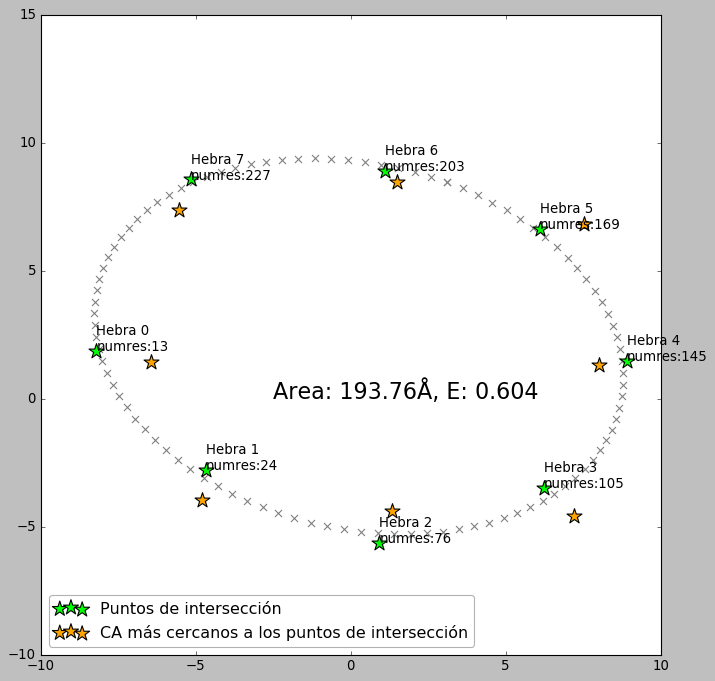

In [48]:
####Hay que probar con un barril que claramente tenga hebras extra 5tnvA00
central_lista=[]
errores_lista=[]
for archivo in lista_arc:
    # Importar datos, crear dataframes de CA y fusionar hebras
    DOM_NAME=archivo.split('_')[0]
    tecnica=archivo.split('_')[1].split('.')[0]
    #if DOM_NAME in ('3ffjB02'):  #'3ffjB02' tiene muchos residuos faltantes en las hebras del pdb
     #   continue
    n_hebras, CA, txt, CB, N, O = datos(archivo, True)    
    ###################################################
    # Crea directorio con nombres nuevos de hebras comenzando de 0 y renombra a las hebras porque cuando se usa fusión algunas hebras se fusionan y se pierde un número en la lista
    dic_renumeracion = renumera_hebras_dic(CA)
    CA.loc[:,"hebra"]=CA["hebra"].map(dic_renumeracion)
    CB.loc[:,"hebra"]=CB["hebra"].map(dic_renumeracion)
    N.loc[:,"hebra"]=N["hebra"].map(dic_renumeracion)
    O.loc[:,"hebra"]=O["hebra"].map(dic_renumeracion)
    ###################################################
    # Trabajar con copia de dataframe para no modificar los originales
    CA_copy = CA.copy()
    CB_copy = CB.copy()
    N_copy = N.copy()
    O_copy = O.copy()
    ##################################################
    #No rotar las coordenadas antes de definir las hebras del barril, sólo hay que sacar los fitlines
    #Al rotar las coordenadas voy a descomponer 
    #print("Calcular los ejes de hebras por primera vez a partir de coordenadas rotadas en chimera")
    CENTRAL_1,EJES_1,DIC_EJES_1,_=central_ax(CA_copy,False,None)
    #################################################
    #print("Calcular adyacencia entre hebras y encontrar hebras del barril con filtro distancia y angulo; Exluir hebras extra")
    DIC_DIS_1 = distancia_interhebra_angulo(DIC_EJES_1,CA_copy,N_copy,O_copy,True)
    GRUPOS_1 = grupos_hebras_conectadas(DIC_DIS_1)
    tamano_1, Ki_1, Kj_1, HEBRAS_barril_1 = grupo_mas_grande(GRUPOS_1)
    ###################################################
    #####SI SE ACTUALIZAN LOS NÚMEROS DE LAS HEBRAS EN LOS DATAAFRAME TAMBIÉN DEBERÍAN ACTUALIZARCE EN LOS DICCIONARIOS de ejes y distancias""""""""""""""""""""""""""""""""""
    #Cordenas_barril_actualización cambia los números de las hebras. por lo tanto todos los diccionarios que se identifiquen con números de las hebras se tienen que actualizar también
    CA_barril_1, N_barril_1, O_barril_1, CB_barril_1 = coordenadas_barril_actualizacion(HEBRAS_barril_1,CA_copy,N_copy,O_copy,CB_copy)
    #print("Calcular los ejes de hebras por segunda vez a partir de coordenadas del barril: actualiza con el número nuevo de hebra")
    CENTRAL_2,EJES_2,DIC_EJES_2,_=central_ax(CA_barril_1,False,None)   
    ###################################################
    #print("Calcular adyacencia entre hebras y encontrar hebras del barril con filtro distancia; Facilitar cerrar el barril")
    DIC_DIS_2 = distancia_interhebra_angulo(DIC_EJES_2,CA_barril_1, N_barril_1, O_barril_1,False)
    GRUPOS_2 = grupos_hebras_conectadas(DIC_DIS_2)
    tamano_2, Ki_2, Kj_2, HEBRAS_barril_2 = grupo_mas_grande(GRUPOS_2)
    ###################################################
    #print("Calculamos el circuito del barril")
    CIRCUITO_1 = barril_circuito(HEBRAS_barril_2, DIC_DIS_2)
    ###################################################
    #print("Quitar residuos atipicos res_atipicos(ca_rotado_new, umbral=0.8)")
    CA_barril_2,CB_barril_2,N_barril_2,O_barril_2, res_expel_1 = res_atipicos(CA_barril_1,CB_barril_1,N_barril_1,O_barril_1,umbral=0.92)
    ###################################################
    #print("Ya que tenemos las hebras que componen al barril, definiremos un nuevo centro del dominio y centraremos, ajustaremos ejes a coordenadas de hebras sin res atipicos. \
    #Tambien obtenemos registro de hebras antiparalelas")
    #Acomodamos ejes en misma dirección que hebra
    #Alineamos a eje z
    direction = [0,0,1]
    #print("retry_rotate despues de definir el barril")
    #Si compara_signo es True, entonces revisa los signos de las hebras
    ERROR_1,CENTRAL_3,EJES_3,DIC_EJES_3,CA_rotado_1,CB_rotado_1,N_rotado_1,O_rotado_1,num_anti_1 = retry_rotate(CA_barril_2,direction,CB_barril_2,N_barril_2,O_barril_2,False) ##Esta es la función que contiene las otras para calcular ejes y rotarlos
    ###################################################
    ##CORRER PARA OBTENER LOS MEJORES EJES POR ÚLTIMA VEZ. PROBAR ASÍ
    ERROR_2,CENTRAL_4,EJES_4,DIC_EJES_4,CA_rotado_2,CB_rotado_2,N_rotado_2,O_rotado_2,num_anti_2 = retry_rotate(CA_rotado_1,direction,CB_rotado_1,N_rotado_1,O_rotado_1,True)
    ####################################################
    #print("Identifica si el eje central el - o + y si es negativo cambia la dirección de todo el dominio.")
    ERROR_3,CENTRAL_5,EJES_5,DIC_EJES_5,CENTRAL_NEG = dominio_positivo(CENTRAL_4,EJES_4,DIC_EJES_4)
    ####################################################
    #print("Guardamos DF con las hebras antiparalelas y con el inverso central")
    df_central_orientacion=df_central_orientacion.append({'barril':DOM_NAME,'central_neg':CENTRAL_NEG,'central':CENTRAL_5,'eje_negativo_hebras':num_anti_2},ignore_index=True)
    ###################################################
    central_lista.append(CENTRAL_5)
    errores_lista.append(ERROR_2)
    ###################################################
   # print("elipse")
    ### Solo calcula elipse si el barril tiene 5 o más hebras
    if tamano_2>5:
        #CA_waist_1, e_1, area_1, rmsd_ajuste_pi_1, perim_1, rotado_ca_elip_1, areas_elipses_1, planos_1, rmsd_ajuste_res_1 = ajusta_elipse_planos(CA_rotado_2, CENTRAL_5, HEBRAS_barril_2, DIC_EJES_5)
        CA_waist_1, e_1, area_1, rmsd_ajuste_pi_1, perim_1, rotado_ca_elip_1, areas_elipses_1, planos_1, rmsd_ajuste_res_1, a_1, b_1, ellipse_points_1, ell_1, P_xy_1, min_area_i_1 = ajusta_elipse_planos(CA_rotado_2, CENTRAL_5, HEBRAS_barril_2, DIC_EJES_5)
        df_elipse=df_elipse.append({'barril':DOM_NAME,'a_calc':a_1,'b_calc':b_1},ignore_index=True)
    else:
        CA_waist_1, e_1, area_1, rmsd_ajuste_pi_1, perim_1, rotado_ca_elip_1, areas_elipses_1, planos_1, rmsd_ajuste_res_1 = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    ###################################################
    ### Construcción del dataframe con información de cada hebra de los barriles (df_1)
    index = pd.MultiIndex.from_product([[DOM_NAME], HEBRAS_barril_2], names=['barril', 'hebra'])
    df_1=pd.DataFrame(index=index,columns = ['rmsd','a', 'b', 'alfa','len','alfa_check'])
    df_1=a_b_rmsd_hebras(HEBRAS_barril_2, DIC_DIS_2, CA_rotado_2, df_1, DIC_EJES_5, DOM_NAME)
    df_1['alfa'] = [angle_between(DIC_EJES_5[i], CENTRAL_5) for i in HEBRAS_barril_2]
    df_1['alfa'] = [180-i if i>90 else i for i in df_1['alfa']] #**
    df_1['alfa_check'] = [angle_between(DIC_EJES_5[i], CENTRAL_5) for i in HEBRAS_barril_2]
    df_1['len'] = list(map(lambda x: len(CA_rotado_2[CA_rotado_2['hebra']==x]), HEBRAS_barril_2))

    ### Construcción del dataframe con los ángulos twist entre hebras adyacentes del barril (df_angulo_twist)
    df_angulo_twist = angulo_twist(df_angulo_twist, HEBRAS_barril_2, DIC_DIS_2, DOM_NAME) 
    df_tw= df_angulo_twist[df_angulo_twist['barril']==DOM_NAME]
    

    ### Construccion del dataframe con los angulos y conexiones ###
    if tamano_2 == 8:
        df_angulo_conexion = angulo_conexion(df_angulo_conexion, CA_rotado_2, N_rotado_2, O_rotado_2, DIC_EJES_5, tecnica, DOM_NAME)

    ### Construccioón del dataframe df_2 con información de los barriles    
    alfa = df_1.loc[DOM_NAME,'alfa'].mean(axis=0)
    a = df_1.loc[DOM_NAME,'a'].mean(axis=0)
    b = df_1.loc[DOM_NAME,'b'].mean(axis=0)
    shear_McL = tamano_2 * b * math.tan(math.radians(alfa)) / a
    shear_proyec = math.nan #shear_proyeccion(dic_fit_new, hebras_barril_new, a)
    R_McL = b / (2 * math.sin(math.pi / tamano_2) * math.cos(math.radians(alfa)))
    df_2=df_2.append({'barril':DOM_NAME,
                      'tecnica':tecnica,
                      'circuito':CIRCUITO_1,
                      'nraw':n_hebras,
                      'n':tamano_2,
                      'e':e_1,
                      'area':area_1,
                      'rmsd_ajuste_pi':rmsd_ajuste_pi_1,
                      'rmsd_ajuste_res':rmsd_ajuste_res_1,
                      'perim':perim_1,
                      'alfa_prom':alfa,
                      'alfa_ds':df_1['alfa'].std(axis=0),
                      'rmsd':df_1['rmsd'].mean(axis=0),
                      'a_prom':a,
                      'a_ds':df_1['a'].std(axis=0),
                      'b_prom':b,
                      'b_ds':df_1['b'].std(axis=0),
                      'shear_McL':shear_McL,
                      'shear_proyec':shear_proyec,
                      'R_McL':R_McL,
                      'R_Murz':(((shear_McL * a)**2 + (tamano_2 * b)**2)**0.5) / (2*tamano_2*math.sin(math.pi/tamano_2)),
                      'area_c':math.pi * R_McL**2,
                      'perim_c':math.pi * R_McL * 2,
                      'twist_McL':a * math.sin(math.radians(alfa)) * math.cos(math.radians(alfa)) / (2 * math.pi * R_McL),
                      'angtw':df_tw['angulo'].mean(axis=0),
                      'angtw_ds':df_tw['angulo'].std(axis=0),
                     }, ignore_index=True)
    

    df_1_todo=pd.concat([df_1_todo, df_1], axis=0)
    pelip=Points(ellipse_points_1)
    fig = plt.figure(figsize=(10,10))
    axel = fig.add_subplot()
    pelip.plot_2d(axel, c='gray', marker='x', s=40)
    Points(P_xy_1).plot_2d(axel, c='lime', marker='*', s=200,label=f"Puntos de intersección")
    Points(CA_waist_1[['x','y','z']].values).plot_2d(axel, c='orange', marker='*', s=200,label=f"CA más cercanos a los puntos de intersección")
    for h,p in enumerate(P_xy_1):
        rum_res=int(CA_waist_1.loc[CA_waist_1['hebra']==h,'num_res'])
        plt.text(p[0],p[1], f"Hebra {h}\nnumres:{rum_res}")# punto {np.round(p,1)}")
    plt.text(-2.5,0, f"Area: {round(area_1,2)}Å, E: {round(e_1,3)}",size=20)
    plt.legend(loc='lower left',fancybox=True, framealpha=0.3)
    #plt.savefig("/mnt/c/Users/Ok/Documents/maestria/Tesis_2023_todo/RESULTADOS_imagenes/Divalent-TIM/"+DOM_NAME+".png", dpi=400)

df_1_todo[['rmsd','a','b']]=df_1_todo[['rmsd','a','b']].apply(pd.to_numeric)
#path_save= Path('/mnt/c/Users/Ok/Documents/maestria/Tesis_2023_todo/RESULTADOS_TABLAS_FINALES/F6_STRIDE-DSSP_ALNSF_FUS')
#df_2.to_csv(path_save/'df2_F6.txt', header=True, index=False, sep='\t')
#df_1_todo.to_csv(path_save/'df_1_todo_F6.txt', header=True, index=True, sep='\t')
#df_angulo_twist.to_csv(path_save/'df_angulo_twist_F6.txt', header=True, index=False, sep='\t') 
#df_angulo_conexion.to_csv(path_save/'ac_F6.txt', header=True, index=False, sep='\t') 
#df_elipse.to_csv(path_save/'elipse_ab_F6.txt', header=True, index=False, sep='\t') 
#df_central_orientacion.to_csv(path_save/'central_orientacion_F6.txt', header=True, index=False, sep='\t') 

In [49]:
rotado_ca_elip=CA_rotado_2.copy()
central=CENTRAL_5
hebras_barril=HEBRAS_barril_2
dic_ejes=DIC_EJES_5

planos={}
n=0
areas_elipses={}
for i in np.arange(rotado_ca_elip['z'].min(),rotado_ca_elip['z'].max(),0.1):
    #Definirmos a central como el eje normal. Podemos hacerlo porque ya alineamos central a eje Z
    #Trazamos un plano en altura z (i)
    plano_i=Plane(point=[0,0,i], normal=central)
    planos_p_int={} #Es un diccionario que guarda los puntos de intersección entre las hebras con cada plano

    #Encuentra los puntos de interseccion del plano con los ejes de las hebras
    for h in hebras_barril:
        linea_h=Line(point=Point(rotado_ca_elip.loc[rotado_ca_elip['hebra']==h,['x','y','z']].mean()),
                               direction=dic_ejes[h])
        point_intersection = plano_i.intersect_line(linea_h)
        planos_p_int[h]=point_intersection

    #Lleva a cabo el ajuste de elipse con los puntos de intersección
    P = np.array(list(planos_p_int.values()))
    ellipse_points, ell, P_xy = fit_an_ellipse(P)
    # Use model only if model estimation succeeds
    if ell.estimate(P_xy):
        a=max(ell.params[2],ell.params[3])
        b=min(ell.params[2],ell.params[3])
        area=a*b*np.pi
        rmsd_ajuste = np.sqrt(np.mean(ell.residuals(P_xy)**2))

        #Guarda el área de cada elipse en una lista
        areas_elipses[n]=area
        #Crea diccionario con puntos de interseccion (indexados por nombre de hebras), planos, area, rmsd_ajuste
            # planos_p_int es otro diccionario con los puntos de intersección entre el plano y cada hebra
        planos[n]=planos_p_int,plano_i,area,rmsd_ajuste,i
        n=n+1
    else:
        n=n+1
        continue

#Busco los puntos de interseccion del plano que tuvieron la menor area en el ajuste de elipses
min_area_i=(min(areas_elipses, key=areas_elipses.get))
#min_area=areas_elipses.index(min(areas_elipses))
print("plano con menor área: ",min_area_i,planos[min_area_i])
#Encuentra los CA más cercanos a los puntos de intersección para poder rastrearlos en chimera
CA_waist=pd.DataFrame(columns=rotado_ca_elip.columns.tolist() + ['distancia'])
for h in hebras_barril:        
    #Calculo la distancia entre cada CA de hebra h, contra el punto de intersección  entre la linea (de la hebra h) y el plano cuya elipse fue la más peque
    rotado_ca_elip.loc[rotado_ca_elip['hebra']==h,'distancia']=rotado_ca_elip.loc[rotado_ca_elip['hebra']==h,['x','y','z']].apply(lambda x: planos[min_area_i][0][h].distance_point(x) , axis=1)
    CA_hebra= rotado_ca_elip.loc[rotado_ca_elip['hebra']==h]
    CA_waist= CA_waist.append(CA_hebra[CA_hebra['distancia'] == CA_hebra['distancia'].min()]) #Infomracion sobre los CA mas cercanos al punto de interseccion
CA_waist.drop(['atomo','cadena'], axis=1, inplace=True) #quitamos 'orient', 'sheet'  porque nuestros txt no los tienen

#Actualiza los valores con los puntos de interseccion que obtuvieron la menor area en el ajuste de elipses
P = np.array(list(planos[min_area_i][0].values())) #Puntos de intesección del plano con el área más pequeña
ellipse_points, ell, P_xy = fit_an_ellipse(P)
a=max(ell.params[2],ell.params[3])
b=min(ell.params[2],ell.params[3])
c=np.sqrt(a**2-b**2)
e=c/a
area=a*b*np.pi
#perim= math.pi*((3.0*(a+b)) - (math.sqrt((3.0*a+b)*(a+3.0*b))))
#rmsd_ajuste_pi = np.sqrt(np.mean(ell.residuals(P_xy)**2))
rmsd_ajuste_res = np.sqrt(np.mean(ell.residuals(np.array(CA_waist[['x','y']]))**2))

plano con menor área:  63 ({0: Point([-8.19600844,  1.85614832, -1.73418539]), 1: Point([-4.66625876, -2.79248392, -1.73418539]), 2: Point([ 0.9316134 , -5.63978808, -1.73418539]), 3: Point([ 6.24214543, -3.47635694, -1.73418539]), 4: Point([ 8.91303189,  1.46716865, -1.73418539]), 5: Point([ 6.11008867,  6.62473005, -1.73418539]), 6: Point([ 1.10572953,  8.89062976, -1.73418539]), 7: Point([-5.16347705,  8.56511728, -1.73418539])}, Plane(point=Point([ 0.        ,  0.        , -1.73418539]), normal=Vector([-1.29464833e-16,  0.00000000e+00,  1.00000000e+00])), 193.76441464743797, 0.2497014615526923, -1.7341853856167297)


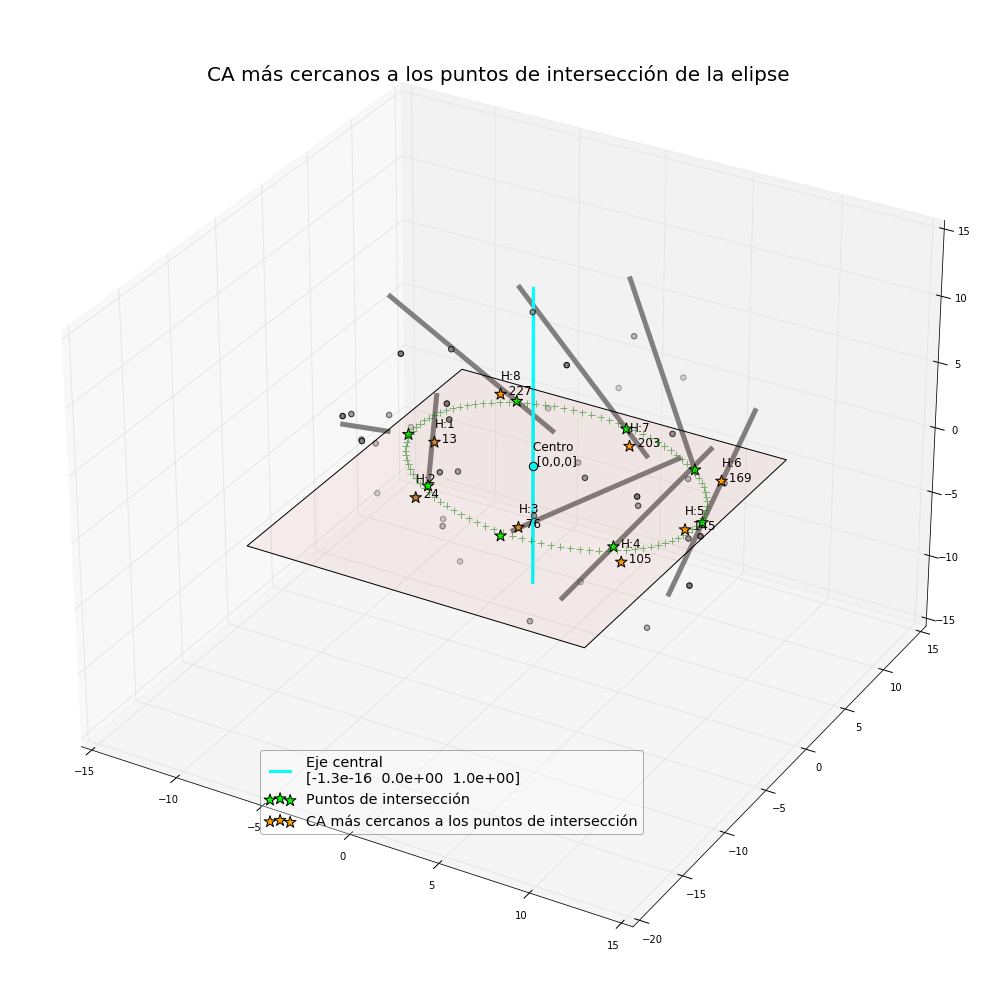

In [50]:
#Graficar los CA (centrados y rotados), junto con sus ejes y el eje central
%matplotlib inline 
plt.style.use("_classic_test_patch")
ellipse_points_fig=pd.DataFrame(ellipse_points)
ellipse_points_fig[2]=planos[min_area_i][4]
CAG=CA_rotado_2
HEBRAS_N=HEBRAS_barril_2
MIS_EJES=DIC_EJES_5
MI_CENTRO=CENTRAL_5
areas_elipses=areas_elipses
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(projection='3d')
plt.style.use('classic')
colores=['k','k','k', 'k', 'k', 'k', 'k','k','k','k'] #,'purple','k']
colores=['gray','gray','gray', 'gray', 'gray', 'gray', 'gray','gray','gray','gray'] #,'purple','k']
#colores=['teal','peru','m', 'g', 'b', 'r', 'y','pink','g','m'] #,'purple','k']
#colores=['b','b','b', 'b', 'b', 'b', 'b','b','b','b'] #,'purple','k']
co=0
for i in HEBRAS_N:
    ax.scatter(CAG.loc[CAG['hebra']==i, 'x'],
               CAG.loc[CAG['hebra']==i, 'y'],
               CAG.loc[CAG['hebra']==i, 'z'],
               marker='o', c=colores[i], s=30),
    ########Ejes de hebras########
    Line(point=CAG.loc[CAG['hebra']==i,['x','y','z']].mean(),
         direction=MIS_EJES[i]).plot_3d(ax,t_1=CAG[CAG['hebra']==0]['z'].max(),
                                            t_2=CAG[CAG['hebra']==0]['z'].min(),
                                            c=colores[i], linewidth=5) #, label='hebra'+str(i))
    ####### poner numero de hebra#####
    coor_h=np.array(CA_waist.loc[CA_waist['hebra']==i, ['x','y','z','num_res']]).flatten()
    ax.text(coor_h[0],coor_h[1],coor_h[2], f"H:{i+1}\n  {coor_h[3]}")# punto {np.round(p,1)}")
    
    #Point(ca_rotado_new.loc[ca_rotado_new['hebra']==i,['x','y','z']].mean()).plot_3d(ax, c="black", marker='x', s=40),
    ########Eje central##########
Line(point=Point(CAG[['x','y','z']].mean()),
                 direction=MI_CENTRO).plot_3d(ax,t_1=CAG['z'].max()+1,t_2=CAG['z'].min()-1, c='cyan',linewidth=3,
                                               label=f"Eje central\n{np.round(MI_CENTRO,17)}"),
Line(point=Point([0,0,0]),
                 direction=[0,0,1]).plot_3d(ax,t_1=CAG['z'].max()+1,t_2=CAG['z'].min()-1, c='cyan',linewidth=3),
Point(CAG[['x','y','z']].mean()).plot_3d(ax, c="cyan", marker='o', s=70),
ax.text(CAG[['x','y','z']].mean()[0],CAG[['x','y','z']].mean()[1],CAG[['x','y','z']].mean()[2], f"Centro \n [0,0,0]")

#plt.legend(loc='upper left')
    
#Grafiacar los puntos de intersección que producen una menor área de elipse
#ax.scatter([np.array(list(planos[1][0].values()))[:,0]],[np.array(list(planos[1][0].values()))[:,1]],[np.array(list(planos[1][0].values()))[:,2]], marker='*', c='mediumpurple',s=150,alpha=1)
#ax.scatter([np.array(list(planos[2][0].values()))[:,0]],[np.array(list(planos[2][0].values()))[:,1]],[np.array(list(planos[2][0].values()))[:,2]], marker='*', c='lime',s=150,alpha=1, label=f"Puntos de intersección")
#ax.scatter([np.array(list(planos[0][0].values()))[:,0]],[np.array(list(planos[0][0].values()))[:,1]],[np.array(list(planos[0][0].values()))[:,2]], marker='*', c='coral',s=150,alpha=1)
ax.scatter([np.array(list(planos[min_area_i][0].values()))[:,0]],[np.array(list(planos[min_area_i][0].values()))[:,1]],[np.array(list(planos[min_area_i][0].values()))[:,2]], marker='*', c='lime',s=150,alpha=1, label=f"Puntos de intersección")

#Graficar los CA mas cercanos a los puntos de intersección
ax.scatter(CA_waist['x'],CA_waist['y'],CA_waist['z'], marker='*', c='orange',s=150,alpha=1,label=f"CA más cercanos a los puntos de intersección")
ax.scatter(ellipse_points_fig[0],ellipse_points_fig[1],ellipse_points_fig[2], marker='+', c='green',s=50,alpha=0.5)


#Graficar plano
#planos[1][1].plot_3d(ax,lims_x=[CAG['x'].min(), CAG['x'].max()], lims_y=[CAG['y'].min(), CAG['y'].max()], alpha=0.1)
planos[min_area_i][1].plot_3d(ax,lims_x=[CAG['x'].min(), CAG['x'].max()], lims_y=[CAG['y'].min(), CAG['y'].max()], alpha=0.05,color='red')
#planos[0][1].plot_3d(ax,lims_x=[CAG['x'].min(), CAG['x'].max()], lims_y=[CAG['y'].min(), CAG['y'].max()], alpha=0.1)
plt.legend(loc='lower left',fancybox=True, framealpha=0.3,bbox_to_anchor=(0.25,0.15))
#plt.savefig("/mnt/c/Users/Ok/Documents/maestria/Tesis_2023_todo/4njhA00_CA-pi.png", dpi=600)
#plt.title('Trazado de planos perpendiculares al eje central del barril',size=20)
plt.title('CA más cercanos a los puntos de intersección de la elipse',size=20)
fig.tight_layout()


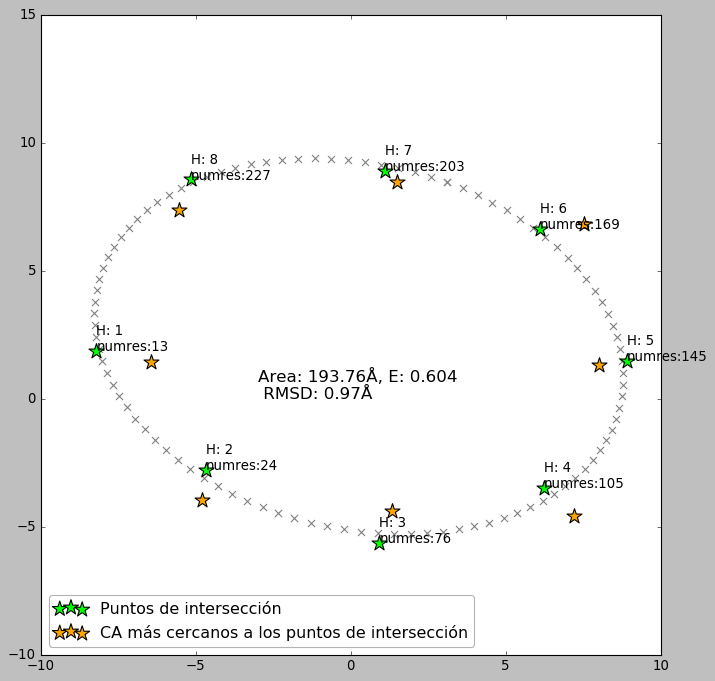

In [51]:
pelip_2=Points(ellipse_points)
fig = plt.figure(figsize=(10,10))
axel = fig.add_subplot()
pelip_2.plot_2d(axel, c='gray', marker='x', s=40)
Points(P_xy).plot_2d(axel, c='lime', marker='*', s=200,label=f"Puntos de intersección")
Points(CA_waist[['x','y','x']].values).plot_2d(axel, c='orange', marker='*', s=200,label=f"CA más cercanos a los puntos de intersección")
for h,p in enumerate(P_xy):
    rum_res=int(CA_waist.loc[CA_waist['hebra']==h,'num_res'])
    plt.text(p[0],p[1], f"H: {h+1}\nnumres:{rum_res}")# punto {np.round(p,1)}")
plt.text(-3,0, f"Area: {round(planos[min_area_i][2],2)}Å, E: {round(e_1,3)}\n RMSD: {round(rmsd_ajuste_res,2)}Å",size=15)
plt.legend(loc='lower left',fancybox=True, framealpha=0.3)
#plt.savefig("/mnt/c/Users/Ok/Documents/maestria/Tesis_2023_todo/4njhA00_elip.png", dpi=600)